#### Mini-Project # 4

This project will focus on suitability analysis with raster data. Your tasks will be both conceptual-level and technical. 

At the conceptual level, you will define a suitability model of your choice, for an area of your choice. See https://en.wikipedia.org/wiki/Suitability_model for a brief description of what a suitability model is. For example, you may be looking for best areas for community gardens: these are often in underutilized land in residential land uses, with good soils, accessible (not steep slope), etc. So you would be looking for areas with a specific type of land use/land cover, with an appropriate range of values of slope, etc. You may build additional criteria based on a range of precipitaiton values, whether the area is affected by wildfires, has mild temperatures, low levels of soil erosion, has vegeration (eg derived from satellite imagery using NDVI), etc. Feel free to use the imagery layers we explored or mentioned during the raster-focused lectures. One of the cells in the last raster notebook contained a list of about a dozen such layers available through AGOL - but feel free to find more. You can use any two of the map combination techniques discussed in the lecture on Thu 5/9. You should clearly identify the map combination technique you use, and discuss any uncertainty issues associated with these specific techniques. 

As the outcome of this part, you will need to a) describe the suitability model you want to develop; b) identify the raster data layers you will use; and c) describe two of the map combination techniques you will use to derive the two suitablity maps, and their pros and cons. In your model you will need to combine at least 3 raster data layers.

The second part will involve implementing your suitability model using arcgis raster functions. For this exercise, we'll only use local functions, and possibly focal_statistics. This is the current state of implementation of raster functions accessible through python API and in ArcGIS Online. Examples of what works are in the lecture notebooks. Look throufgh the last notebook carefully, as there are a few extra cells not shown in the lecture, which demonstrate *working* map combination examples for different types of layers. 

Be creative - but I'd rather not have you wander into blind alleys too much as you look for a declared function and it is simply not there. Note that since some functions are associated with raster services, they depend on the version of the server a particular imagery layer is served from. See in the lecture notebooks how you can retrieve the version of API supported by each layer, and which functions are supported in each API. 

The third part will be a brief write-up comparing the two output rasters generated for your suitability model using the two map combination techniques. 

The notebook should include documentation of the steps, as usually.

### Names: Bolin Yang, Shuibenyang Yuan

### IDs: A92111272, A14031016


1. Formulate a suitability model (markdown, about 100 words)

Our goal is to find suitable housing in San Diego areas, based on three factors (mean rainfall, mean temperture and air pollution). We picked these three features based on a census we have done to our friends and classmates. Most of them believe that these three factors are the most important ones in finding suitable housing. We will find the imagery layers for these three factors, and combine them into a single raster using two different map combination techniques. During the process, we will normailize the values in each rasters based on the data and definitions in each features. (Thus, the value will become binary values 0 or 1) The two different map combination will be Exclusionary screening in Dominance rules and Voting Tabulation in Contributory rules. In the final part, we will compare and analyze the result generated by the map combination.

In [1]:
# 2. Imports, etc.
%matplotlib inline 
from arcgis import GIS
gis = GIS(username='boy015_UCSDOnline8')
import arcgis.raster
from arcgis.raster import *
from arcgis.geometry import *
from arcgis.geocoding import geocode

Enter password: ········


In [2]:
# 3. List imagery layers to be used in your model. This cell should contian layer definitions. 
# Include at least three initial raster sources. 

In [3]:
# YOUR CODE HERE
# rainfall imagery layers
# This layer displays average annual rainfall in inches for the period of January 1971 through December 2009.
# Examining climate over time is useful when quantifying the effects of climate changes on species’ distributions 
# for past, current, and forecasted scenarios.  The relationships established between species demographics and 
# distributions with bioclimatic predictors can inform land managers of climatic effects on species during 
# decision making processes.
usa_mean_rainfall = \
ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Rainfall/ImageServer", gis)

# temperature imagery layers
# Annual mean temperature is mean of the average temperatures for each month in degrees Celsius 
# for the period of January 1971 through December 2009. The relationships established between species 
# demographics and distributions with bioclimatic predictors can inform land managers of climatic effects 
# on species during decision making processes.
usa_mean_temperature = \
ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Temperature/ImageServer", gis)

# air pollution imagery layers
# The data set represents a series of three-year running mean grids (1998-2012) of fine particulate matter 
# (solid particles and liquid droplets) that were derived 
# from a combination of MODIS (Moderate Resolution Imaging Spectroradiometer), 
# MISR (Multi-angle Imaging SpectroRadiometer) and SeaWIFS (Sea-Viewing Wide Field-of-View Sensor) 
# AOD satellite retrievals. Together the grids provide a continuous surface of concentrations 
# in micrograms per cubic meter of particulate matter 2.5 micrometers or smaller (PM2.5) 
# for health and environmental research. 
global_air_pollution = \
ImageryLayer('https://sedac.ciesin.columbia.edu/arcgis/rest/services/sedac/sdei_global_annual_avg_pm2_5_2001_2010_image_service/ImageServer',gis)

In [4]:
# 4. Derive the area of interest (AOI) and its geometry and extent. 
# The smaller the area the better (so that you don't run into raster size limitations)

In [5]:
# YOUR CODE HERE
# we choose San Diego as our area of interest
# find geocode of san diego and extent and find geometry and spatial reference of the area
study_area_gcd = geocode(address='San Diego County, CA', out_sr=usa_mean_rainfall.extent['spatialReference'])
study_area_extent = study_area_gcd[0]['extent']
counties_item = gis.content.search('USA Counties generalized', 'Feature Layer', outside_org=True)[0]
counties_lyr = counties_item.layers[0]
study_area_query = counties_lyr.query("FIPS='06073'", return_geometry=True)
study_area_geom= study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference

# define more exact location and update the spatial reference
study_area_ex = Geometry(study_area_geom).geoextent 
tup = (('xmin',study_area_ex[0]), ('ymin', study_area_ex[1]), ('xmax',study_area_ex[2]), ('ymax', study_area_ex[3]))
study_area_extent = dict(tup)
crs = "{'latestwkid':3857, 'wkid':102100}"
study_area_extent.update({'spatialReference':{'latestwkid':3857, 'wkid':102100}})

5. Name the two map combination techniques you will use to combine the data and describe their pros and cons (markdown) 

We used two kind of map combination techniques:
####   - Dominance Exclusionary Screening:
        - we used a * b * c to perform dominance exclusionary screening. a and b and c are all binary layers, and we have preprocessed to binary form, it will output the raster that all label 1 areas that all three rasters interesct. It will select the area that have qualify the condition of good condition of living. 
        - Pros: it will accurately select the areas that qualify all the condition, and they will for sure under the criteria of 'good for living'
        - Cons: Exclusion screening is too strict, it will output too little areas which have all 1 labels in all three maps. It will not output the rank of areas that are good for living. For instance, it will not sort out the areas who are good in air condition and raining but not good in temperature.
        
####   - Contributory Voting Tabulation:
        - we used contributory voting tabulation as our second choice of combining raster layers. We perform this by using a + b + c in raster calculator. The voting tabulation shows how many positive (or negative) factors occur at a location. We can rank the best area for living by ranking them.
        - Pros: it perserved all the details of the areas qualify how many conditions qualify the condition of good condition of living.
        - Cons: This technique will lead a inaccurate result. Because each attributes of 'good for living' weights differently, simplying adding them up with contributory voting tabulation will make the rank inaccurate. For example, some people do not like rain, they may weight raining as the most attribute that for good for living.

In [6]:
# 6. Prepare your input layers for map combination: 
# clip to AOI, remap/normalize, add color map, visualize the layers and legends. 

In [7]:
# YOUR CODE HERE
# Rainfall layers
# clip usa mean rainfall layer to AOI, remap/normalize, add color map, visualize the layers and legends. 
rain_study_area = clip(raster=usa_mean_rainfall, geometry=study_area_geom)

# create map for the raster
# we define the 0-20 mm as suitable place to live based on relative data in san diego, and label as 1,
# we define the 20 and above mm as not suitable place to live based on relative data in san diego, and label as 0
map_rain = gis.map()
map_rain.extent = study_area_extent
map_rain.legend=True
clrmap5 =  [[1,173, 233, 255],[0,28, 105, 206]]
rain_n = remap(raster=rain_study_area,
                  input_ranges=[0, 20, 20, 50],
                  output_values=[1,0],  astype='U8')
rain_n_c = colormap(rain_n, colormap=clrmap5)
map_rain.add_layer(rain_n_c)
map_rain

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [8]:
# Temperature layers
# clip usa mean temperature layer to AOI, remap/normalize, add color map, visualize the layers and legends.
temperature_study_area = clip(raster=usa_mean_temperature, geometry=study_area_geom)

# create map for the raster
# we define the 16 and above degree as suitable place to live in san diego, and label as 1,
# we define the 16 and below degree as not suitable place to live in san diego, and label as 0
# based on the article found in https://www.scientificamerican.com/article/why-people-feel-hot/?redirect=1
map_temperature = gis.map()
map_temperature.extent = study_area_extent
map_temperature.legend=True
clrmap5 =  [[0,255, 219, 181],[1,255, 101, 12]]
temperature_n = remap(raster=temperature_study_area,
                  input_ranges=[10, 16, 16, 23],
                  output_values=[0,1],  astype='U8')
temperature_n_c = colormap(temperature_n, colormap=clrmap5)
map_temperature.add_layer(temperature_n_c)
map_temperature

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [9]:
# Air pollution layers
# clip global air pollution layer to AOI, remap/normalize, add color map, visualize the layers and legends.
air_pollution_study_area = clip(raster=global_air_pollution, geometry=study_area_geom)

# create map for the raster
# we define the 0-8 index as suitable place to live based on relative data in san diego, and label as 1,
# we define the 8 and above index as not suitable place to live based on relative data in san diego, and label as 0
map_air_pollution = gis.map()
map_air_pollution.extent = study_area_extent
map_air_pollution.legend=True
clrmap5 =  [[1, 226, 226, 226], [0, 79, 79, 79]]
air_pollution_n = remap(raster=air_pollution_study_area,
                  input_ranges=[0, 8, 8, 20],
                  output_values=[1,0],  astype='U8') #TO BE CHANGED
air_pollution_n_c = colormap(air_pollution_n, colormap=clrmap5)
map_air_pollution.add_layer(air_pollution_n_c)
map_air_pollution

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [10]:
# 7a. Generate a composite raster layer for your first map combination technique
# name of the technique (refer to lecture PPT):

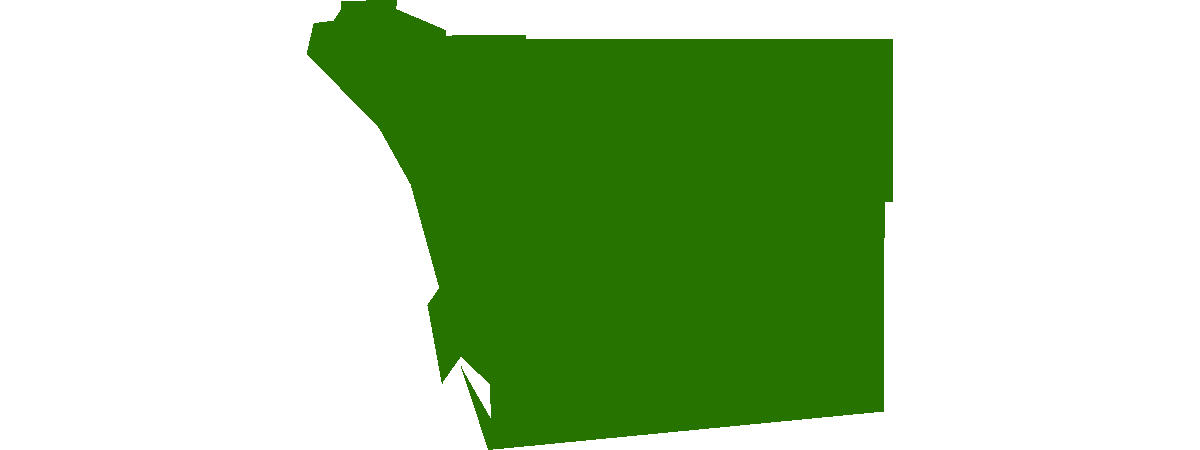

In [11]:
# before combine we need to prepare a dummy layer in order to make raster calculator successful
usa_elevation = ImageryLayer('https://elevation.arcgis.com/arcgis/rest/services/WorldElevation/Terrain/ImageServer',gis)
slope_lyr = slope(dem=usa_elevation, slope_type='DEGREE', z_factor=10)
slope_lyr.extent = study_area_extent
slope_study_area = clip(raster=slope_lyr, geometry=study_area_geom)

# define colors to be maped
clrmap2 =  [[0, 230, 0, 0], [1, 38, 115, 0]]
slope_b = remap(raster=slope_study_area,
input_ranges=[0.0,90, 90.0,90.0],
output_values=[1,0], astype='U8')
slope_b_c = colormap(slope_b, colormap=clrmap2)
slope_b_c

In [12]:
# YOUR CODE HERE
# First method: Exclusionary screening in Dominance rules
# define colors to be maped
clrmap2 =  [[0, 230, 0, 0], [1, 38, 115, 0]]

# combine the three rasters into one using raster calculator based on Exclusionary screening in Dominance rules
# this is where the error occurs, we will include this error in the report in the extra credit
# basically it is because the dataset is too large to be used in raster calculator function
rc_out1 = \
raster_calculator(rasters = [slope_b_c,rain_n_c,air_pollution_n_c,temperature_n_c], \
    input_names = ["D","a","b","c"], expression = "D * a * b * c", extent_type='FirstOf',
                  cellsize_type='FirstOf', astype='UNKNOWN')

# assuming the previous function works, the code for showing the raster, 0 for not suitable and 1 for suitable relatively
# we use red color for the label 0 and green color for the label 1
rc_out_b_c = colormap(rc_out1, colormap=clrmap2)
map_ras = gis.map()
map_ras.extent = study_area_extent
map_ras.legend=True
map_ras.add_layer(rc_out_b_c)
map_ras

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [13]:
# 7b. Generate a composite raster layer for your second map combination technique
# name of the technique (refer to lecture PPT):

In [14]:
# YOUR CODE HERE
# Second method: Voting Tabulation in Contributory rules
# define colors to be maped
clrmap4 =  [[1, 244, 66, 66], [2, 244, 178, 65], [3, 220, 244, 65], [4, 65, 244, 76]]

# combine the three rasters into one using raster calculator based on Voting Tabulation in Contributory rules
# this is where the error occurs, we will include this error in the report in the extra credit
# basically it is because the dataset is too large to be used in raster calculator function
rc_out2 = \
raster_calculator(rasters = [slope_b_c,rain_n_c,air_pollution_n_c,temperature_n_c], \
    input_names = ["D","a","b","c"], expression = "D + a + b + c", extent_type='FirstOf',
                      cellsize_type='FirstOf', astype='UNKNOWN')

# assuming the previous function works, the code for showing the raster,
# 1 for very not suitable and 2 for not suitable, 3 for suitable, 4 for very suitable relatively
# we use red color for the label 1 and orange color for the label 2, yellowish green color for the label 3
# green color for the label 4
rc_out_2_b_c = colormap(rc_out2, colormap=clrmap4)
map_ras2 = gis.map()
map_ras2.extent = study_area_extent
map_ras2.legend=True
map_ras2.add_layer(rc_out_2_b_c)
map_ras2

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [15]:
# 8. Compare the results, and describe how different map combination techniques resulted in different outputs (or not.)
# 

In [16]:
# YOUR CODE HERE

# Assuming there was no error in the raster calculator functions, we compare the map in the below
map_ras

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [17]:
map_ras2

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In both map combination techniques, we found that there are quite a lot of suitable and unsuitable places in San Diego. Comparing to Exclusionary screening in Dominance rules in the first map, we found more suitable raster cells in Voting Tabulation in Contributory rules in the second map, which means that there are more places to choose for housing in the second map. The reason for this is simply due to voting mapping allows people to tell how many features that are suitable in each area. However, the exclusionary screening only presents places that has all features that are suitable. As a result, there are a lot of relatively suitable place are being ignored in the first mapping techniques (Exclusionary screening in Dominance rules). However, both of the techniques are not that great in our opinon, since everyone values the features importance differently, if anyone want to use this map, we should use weighted voting techniques according to such person's peference in order to find best suitable places according to peronal needs.

### Extra Credict: Issue Report

Our map only works because we add the extra layer (slope) in the map. if we do not add this layer, the map will not show. And we documented such issue.

The issue mainly happens in the raster combination.<br> 
Here is the question we found:<br>
We tried different ways to perform map combination technique, both adding and multiplying.<br>
They output results with the same error message : "Unable to complete operation.
Authentication token required. (status code 499)." <br>
After we carefully saw the problem, we found that whenever two large raster combines, the server will automatically complain the calculation.<br>
In our scenario: we have three layers: A: 'usa_mean_rainfall', B: 'usa_mean_temperature', and C: 'global_air_pollution'. <br>
We can do calculation in following scenarios:<br>
    - A times or adds C
    - B times or adds C
The server will output error in following scenarios: <br>
    - A times or adds B
    - (A times or add B) times or add C
    - (A times or add C) times or add B
    - (B times or add A) times or add C
    - (B times or add C) times or add A
    - (C times or add A) times or add B
    - (C times or add B) times or add A
Since 'usa_mean_rainfall' and 'usa_mean_temperature' came from the same source (both under the link: https://landscape3.arcgis.com/arcgis/rest/services/" , we can exclude the possibility the error comes from the problem of datasets. <br>

The error occurs in the following raster_calculator functions:
    - rc_out1 = raster_calculator(rasters = [rain_n_c,air_pollution_n_c,temperature_n_c], \
                    input_names = ["a","b","c"], expression = "a * b * c", extent_type='FirstOf',
                    cellsize_type='FirstOf', astype='UNKNOWN')
    - rc_out2 = raster_calculator(rasters = [rain_n_c,air_pollution_n_c,temperature_n_c], \
                    input_names = ["a","b","c"], expression = "a + b + c", extent_type='FirstOf',
                    cellsize_type='FirstOf', astype='UNKNOWN')
            
We performed folloing commands to exam the attributes of the error, and the output is:
    - >>> temperature_n_c.compute_histograms(geometry=study_area_geom)
    - {'histograms': [{'size': 2, 'min': -0.5, 'max': 1.5, 'counts': [4146, 8445]}]}
    - ###The histogram summary of our binary transformed raster of 'usa_mean_temperature' in study area###
    - ###########################################################################################################
    - >>> rain_n_c.compute_histograms(geometry=study_area_geom)
    - {'histograms': [{'size': 2, 'min': -0.5, 'max': 1.5, 'counts': [2338, 8728]}]}
    - ###The histogram summary of our binary transformed raster of 'usa_mean_rainfall' in study area###
    - ###########################################################################################################
    - >>> air_pollution_n_c.compute_histograms(geometry=study_area_geom)
    - {'histograms': [{'size': 2, 'min': -0.5, 'max': 1.5, 'counts': [21, 74]}]}
    - ###The histogram summary of our binary transformed raster of 'global_air_pollution' in study area###
Based on the observation above, we found that the layer 'usa_mean_temperature' and 'usa_mean_rainfall' are large raster with significantly large sets: one counts as 4146, 8445 and the other counts as 2338 and 8728.<br>
While, the raster 'air_pollution_n_c' counts as only 21, 74, which is a significantly smaller layer.<br>
Then, we suggest the combining of two large raster will demand relatively high computation in the Arcgis server, which will interrupt the raster calculation process.<br>

In [18]:
# Please let us know how much time you spent on this project, in hours: 
# (we will only examine distributions and won't look at individual responses)
assignment_timespent = 25
extracredit_timespent = 5